# Youtube Channel Analysis

In this notebook I use Google's Youtube API to fetch information on various youtube channels and videos, analyzing... FINISH THIS

,specifically looking at Medical School Information YouTube Channels...

(CITE YOUTUBE AND ORIGINAL REPO)

In [122]:
#Import necessary libraries

from dotenv import load_dotenv
from googleapiclient.discovery import build
import pandas as pd
import os
from IPython.display import JSON

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from wordcloud import WordCloud

In [3]:
#Load api key

load_dotenv()
api_key = os.getenv("YOUTUBE_API_KEY")

In [6]:
# Initializes the Youtube Data API Client 
# Get the channel IDs of the channels we are interested in analyzing so we can use it to fetch data

api_service_name = "youtube"
api_version = "v3"
youtube = build(api_service_name, api_version, developerKey=api_key)

def get_channel_id_by_name(channel_name):
    try:
        search_response = youtube.search().list(
            q=channel_name,
            part='id,snippet',
            maxResults=1,
            type='channel'
        ).execute()

        for search_result in search_response.get('items', []):
            if search_result['id']['kind'] == 'youtube#channel':
                return search_result['id']['channelId'], search_result['snippet']['title']
    except HttpError as e:
        print(f"An HTTP error {e.resp.status} occurred:\n{e.content}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return None, None

MSI_id, MSI_title = get_channel_id_by_name('Med School Insiders')
print(f"Channel Title: {MSI_title}, Channel ID: {MSI_id}")

Channel Title: Med School Insiders, Channel ID: UC3VWbWk8qDBiF0741izgpQg


In [8]:
#Create list containing IDs of youtube channels we are interested in

channel_ids = ['UC3VWbWk8qDBiF0741izgpQg', #Med School Insiders
                #Shemmassian Academic Consulting and more channels here...
              ]

## Getting Channel Statistics

First, we will explore the overall statistics of each YouTube Channel, specifically looking at at the number of subscribers, the total views of the channel, the total number of videos, and the the playlist ID

In [9]:
# Fetches relevant information

request = youtube.channels().list(
    part="snippet, contentDetails, statistics",
    id=''.join(channel_ids)
)

response = request.execute()

JSON(response)

<IPython.core.display.JSON object>

In [10]:
def get_channel_stats(youtube, channel_ids):
    """
    Fetches statistics for a list of YouTube channel IDs using the YouTube Data API.

    Parameters:
    - youtube (Resource): An authorized Google API client instance for YouTube Data API v3.
    - channel_ids (list of str): A list of YouTube channel IDs

    Returns:
    -  pandas.DataFrame: A DataFrame containing the channel name, subscribers count, total views,
      total number of videos, and uploads playlist ID for each channel. Each row represents one channel.

    Raises:
    - HttpError: An error response from the API call
    - ValueError: If 'channel_ids' is an empty list
      
    """

    all_data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    #loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }

        all_data.append(data)

    return pd.DataFrame(all_data)

In [15]:
channel_stats = get_channel_stats(youtube, channel_ids)
playlist_ids = channel_stats.set_index('channelName')['playlistId'].to_dict()
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Med School Insiders,1720000,117392865,363,UU3VWbWk8qDBiF0741izgpQg


## Getting Video Statistics

Now that we have explored the channel IDs, let's look at video IDs

In [18]:
playlist_id = playlist_ids['Med School Insiders']

def get_video_ids(youtube, playlist_id):

    video_ids = []
    
    request = youtube.playlistItems().list(
            part="snippet, contentDetails",
            playlistId=playlist_id,
            maxResults = 50
        )
    response = request.execute()

    for item in response["items"]:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet, contentDetails",
            playlistId=playlist_id,
            maxResults = 50,
            pageToken=next_page_token
        )
        response = request.execute()
    
        for item in response["items"]:
            video_ids.append(item['contentDetails']['videoId'])
    
        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [61]:
video_ids = get_video_ids(youtube, playlist_id)
len(video_ids)

363

In [73]:
import pandas as pd

def get_video_details(youtube, video_ids):
    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i: i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {
                'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'], 
                'statistics': ['viewCount', 'likeCount', 'favoriteCount', 'commentCount'],
                'contentDetails': ['duration', 'definition', 'caption']
            }
            
            video_info = {'video_id': video['id']}

            for k in stats_to_keep:
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except KeyError:
                        video_info[v] = None

            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

In [74]:
video_df = get_video_details(youtube, video_ids)
video_df.tail()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favoriteCount,commentCount,duration,definition,caption
358,pL71FE-JYzk,Med School Insiders,How to Study Effectively and Efficiency as a P...,I go over how to increase your overall efficie...,"[how to study efficiently, premed study tips, ...",2016-10-19T21:17:51Z,106667,2646,0,33,PT4M33S,hd,true
359,wyi9NGWohqM,Med School Insiders,Letters of Recommendation for Pre-Meds and Med...,How to Ask for Letters of Recommendation for M...,"[letters of recommendation, letters of rec, ho...",2016-10-19T06:16:25Z,5361,154,0,6,PT3M23S,hd,false
360,P7M7e2TDLSM,Med School Insiders,Letters of Recommendation for Pre-Meds and Med...,Letters of Recommendation for Getting into Med...,"[med school, letters of rec, letters of recomm...",2016-10-07T23:40:45Z,15368,274,0,13,PT3M59S,hd,false
361,RFMgQshwGZE,Med School Insiders,Stop Procrastinating and Be Productive - How t...,Procrastination as a pre-med or medical studen...,"[premed, premedical, medical school, med stude...",2016-10-06T07:20:49Z,72296,2455,0,62,PT4M37S,hd,true
362,1JqFJdptTto,Med School Insiders,Pre-Med Study Strategies - What I Wish I Knew ...,How to Study Better and Get Better Grades: Lea...,"[premed, medical school, premedical, how to st...",2016-10-05T01:09:20Z,740095,27283,0,366,PT11M7S,hd,true


# Data Preprocessing and Preperation

In [75]:
video_df.isnull().any()

video_id         False
channelTitle     False
title            False
description      False
tags             False
publishedAt      False
viewCount        False
likeCount        False
favoriteCount    False
commentCount     False
duration         False
definition       False
caption          False
dtype: bool

In [76]:
video_df.dtypes

video_id         object
channelTitle     object
title            object
description      object
tags             object
publishedAt      object
viewCount        object
likeCount        object
favoriteCount    object
commentCount     object
duration         object
definition       object
caption          object
dtype: object

In [77]:
numeric_cols = ['viewCount', 'likeCount', 'favoriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [78]:
# Publish day in the week

from dateutil import parser

video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['publishedDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [82]:
# convert duration to seconds
import isodate 
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())

In [83]:
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,491.0,PT8M11S
1,628.0,PT10M28S
2,748.0,PT12M28S
3,619.0,PT10M19S
4,486.0,PT8M6S
...,...,...
358,273.0,PT4M33S
359,203.0,PT3M23S
360,239.0,PT3M59S
361,277.0,PT4M37S


In [81]:
#Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: len(x))
video_df.tail()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favoriteCount,commentCount,duration,definition,caption,publishedDayName,durationSecs,tagCount
358,pL71FE-JYzk,Med School Insiders,How to Study Effectively and Efficiency as a P...,I go over how to increase your overall efficie...,"[how to study efficiently, premed study tips, ...",2016-10-19 21:17:51+00:00,106667,2646,0,33,PT4M33S,hd,true,Wednesday,0 days 00:04:33,14
359,wyi9NGWohqM,Med School Insiders,Letters of Recommendation for Pre-Meds and Med...,How to Ask for Letters of Recommendation for M...,"[letters of recommendation, letters of rec, ho...",2016-10-19 06:16:25+00:00,5361,154,0,6,PT3M23S,hd,false,Wednesday,0 days 00:03:23,12
360,P7M7e2TDLSM,Med School Insiders,Letters of Recommendation for Pre-Meds and Med...,Letters of Recommendation for Getting into Med...,"[med school, letters of rec, letters of recomm...",2016-10-07 23:40:45+00:00,15368,274,0,13,PT3M59S,hd,false,Friday,0 days 00:03:59,10
361,RFMgQshwGZE,Med School Insiders,Stop Procrastinating and Be Productive - How t...,Procrastination as a pre-med or medical studen...,"[premed, premedical, medical school, med stude...",2016-10-06 07:20:49+00:00,72296,2455,0,62,PT4M37S,hd,true,Thursday,0 days 00:04:37,15
362,1JqFJdptTto,Med School Insiders,Pre-Med Study Strategies - What I Wish I Knew ...,How to Study Better and Get Better Grades: Lea...,"[premed, medical school, premedical, how to st...",2016-10-05 01:09:20+00:00,740095,27283,0,366,PT11M7S,hd,true,Wednesday,0 days 00:11:07,28


# Analysis Ideas 
- Average views per video
- Likes and comments vs. views
- Title length vs. views
- Video duration
- Video upload schedules

## Best Performing Videos

/var/folders/_h/c16rt2dj0zj5gzghtlmkkdrh0000gn/T/ipykernel_63500/3135926202.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


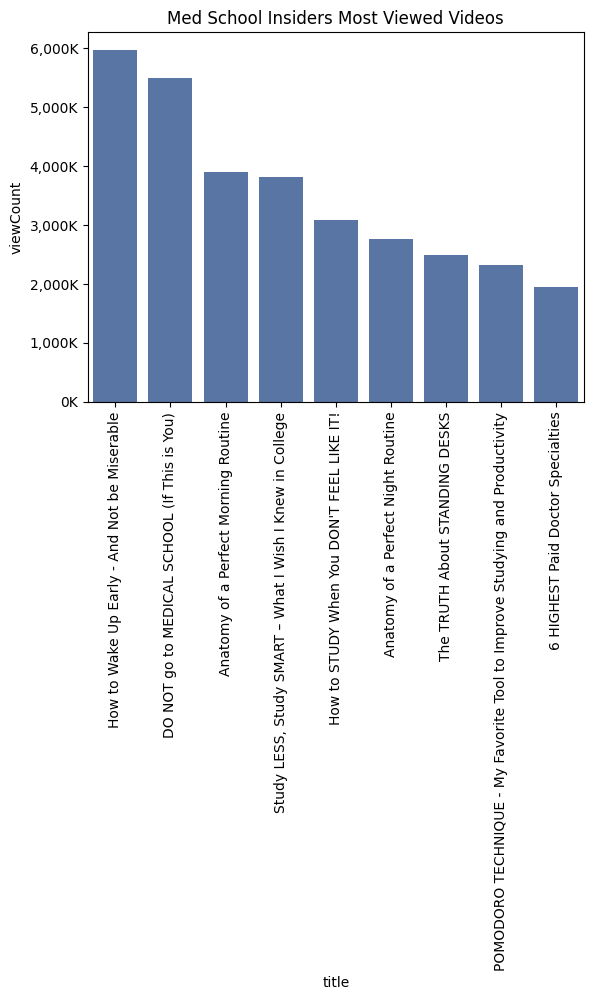

In [94]:
import matplotlib.ticker as ticker
sns.set_palette('deep')

ax = sns.barplot(x='title', y='viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
ax.set_title('Med School Insiders Most Viewed Videos')
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## Worst Performing Videos

/var/folders/_h/c16rt2dj0zj5gzghtlmkkdrh0000gn/T/ipykernel_63500/1115905364.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/Users/danieltiourine/anaconda3/envs/youtube-data/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128218 (\N{BOOKS}) missing from current font.
  func(*args, **kwargs)
/Users/danieltiourine/anaconda3/envs/youtube-data/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.
  func(*args, **kwargs)
/Users/danieltiourine/anaconda3/envs/youtube-data/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128218 (\N{BOOKS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/danieltiourine/anaconda3/envs/youtube-data/lib/python3.12/site-packages/IPython/core/pylabtools.py:17

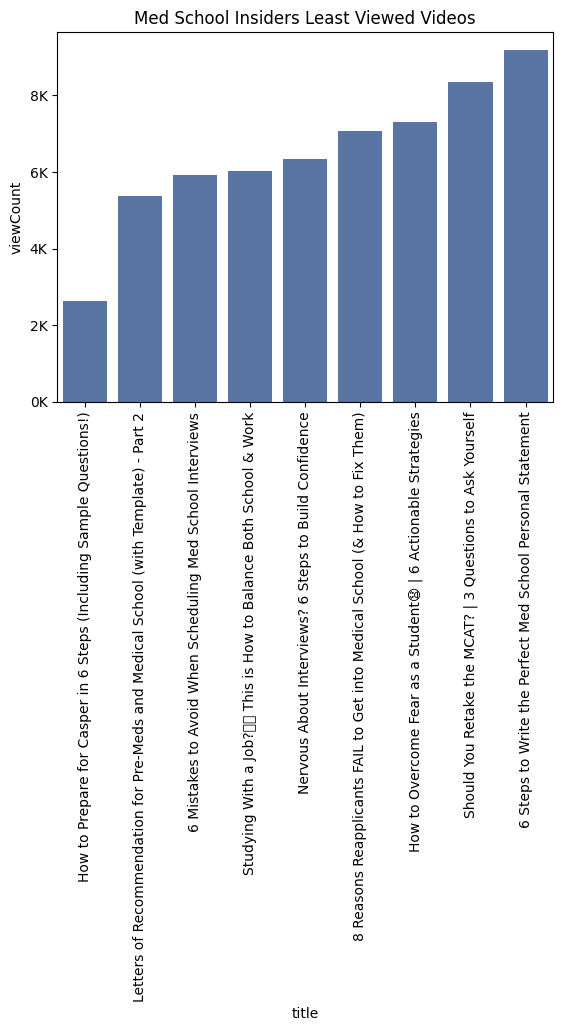

In [95]:
ax = sns.barplot(x='title', y='viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
ax.set_title('Med School Insiders Least Viewed Videos')
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### View distribution per video (MODIFY THIS SO IT INCLUDES MULTIPLE CHANNELS, CHECK 18:15 OF YT VIDEO)

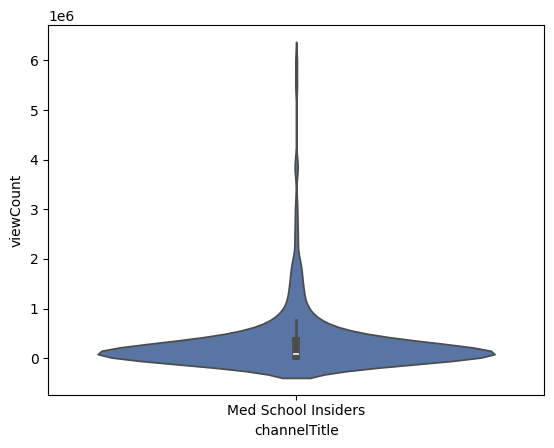

In [108]:
sns.violinplot(x='channelTitle', y='viewCount', data=video_df)
plt.show()

### Views vs. likes and comments

<Axes: xlabel='viewCount', ylabel='commentCount'>

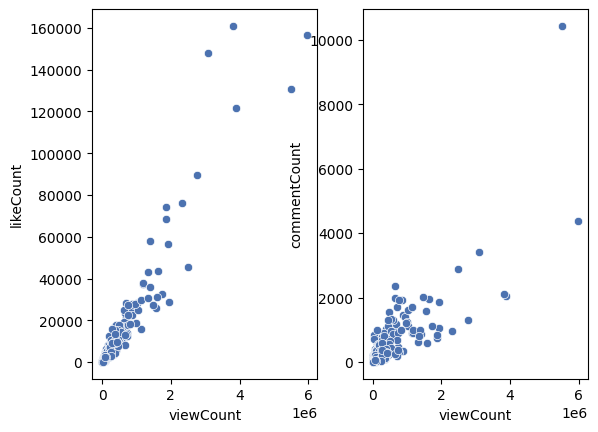

In [112]:
fig, ax = plt.subplots(1, 2)
sns.scatterplot(data=video_df, x='viewCount', y='likeCount', ax = ax[0])
sns.scatterplot(data=video_df, x='viewCount', y='commentCount', ax = ax[1])

In [115]:
view_comment_correlation = video_df['viewCount'].corr(video_df['commentCount'])
view_like_correlation = video_df['viewCount'].corr(video_df['likeCount'])
print(f'View vs. Likes Correlation: {round(view_like_correlation, 2)}')
print(f'View vs. Comments Correlation: {round(view_comment_correlation, 2)}')

View vs. Likes Correlation: 0.95
View vs. Comments Correlation: 0.82


### Video Duration

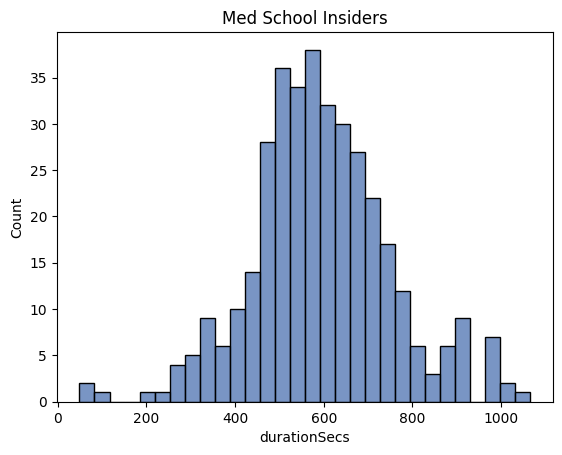

In [120]:
ax = sns.histplot(data = video_df, x = 'durationSecs', bins=30)
ax.set_title('Med School Insiders')
plt.show()

In [123]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis('off');

wordcloud = WordCloud(width=2000, height=1000, random_state = 1, background_color = 'black',
                      colormap='viridis', collocations=False).generate(all_words_str)

plot_cloud(wordcloud)

NameError: name 'stopwords' is not defined

### Upload Schedule